In [1]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [4]:
def triple_timeframe_confirmation(df, kdj_period=9):
    """Multi-timeframe KDJ confirmation (hourly, 15m, 5m)"""
    # Resample to different timeframes
    hourly = df.resample('1H').agg({
        'open': 'first', 
        'high': 'max',
        'low': 'min',
        'close': 'last'
    }).ffill()
    
    five_min = df.resample('5T').agg({
        'open': 'first', 
        'high': 'max',
        'low': 'min',
        'close': 'last'
    }).ffill()
    
    # KDJ Calculation for each timeframe
    def calc_kdj(data):
        low_min = data['low'].rolling(kdj_period, min_periods=1).min()
        high_max = data['high'].rolling(kdj_period, min_periods=1).max()
        rsv = 100 * (data['close'] - low_min) / (high_max - low_min + 1e-8)
        K = rsv.ewm(span=3, adjust=False).mean()
        return K
    
    k_hourly = calc_kdj(hourly).reindex(df.index).ffill()
    k_fivemin = calc_kdj(five_min).reindex(df.index).ffill()
    k_current = calc_kdj(df)
    
    # Directional alignment
    direction = np.sign(k_current.diff()) + np.sign(k_hourly.diff()) + np.sign(k_fivemin.diff())
    return direction / 3.0

In [ ]:
evaluator.set_factor(
    factor_data_or_func=triple_timeframe_confirmation,
    factor_name='triple_timeframe_confirmation'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): 0.032582
   Rank_IC (Spearman): 0.033169
📊 信息比率:
   IR: nan
   有效分组数: 6
📊 因子分布:
📋 数据概况:
   数据长度: 130378
   因子列: triple_timeframe_confirmation
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


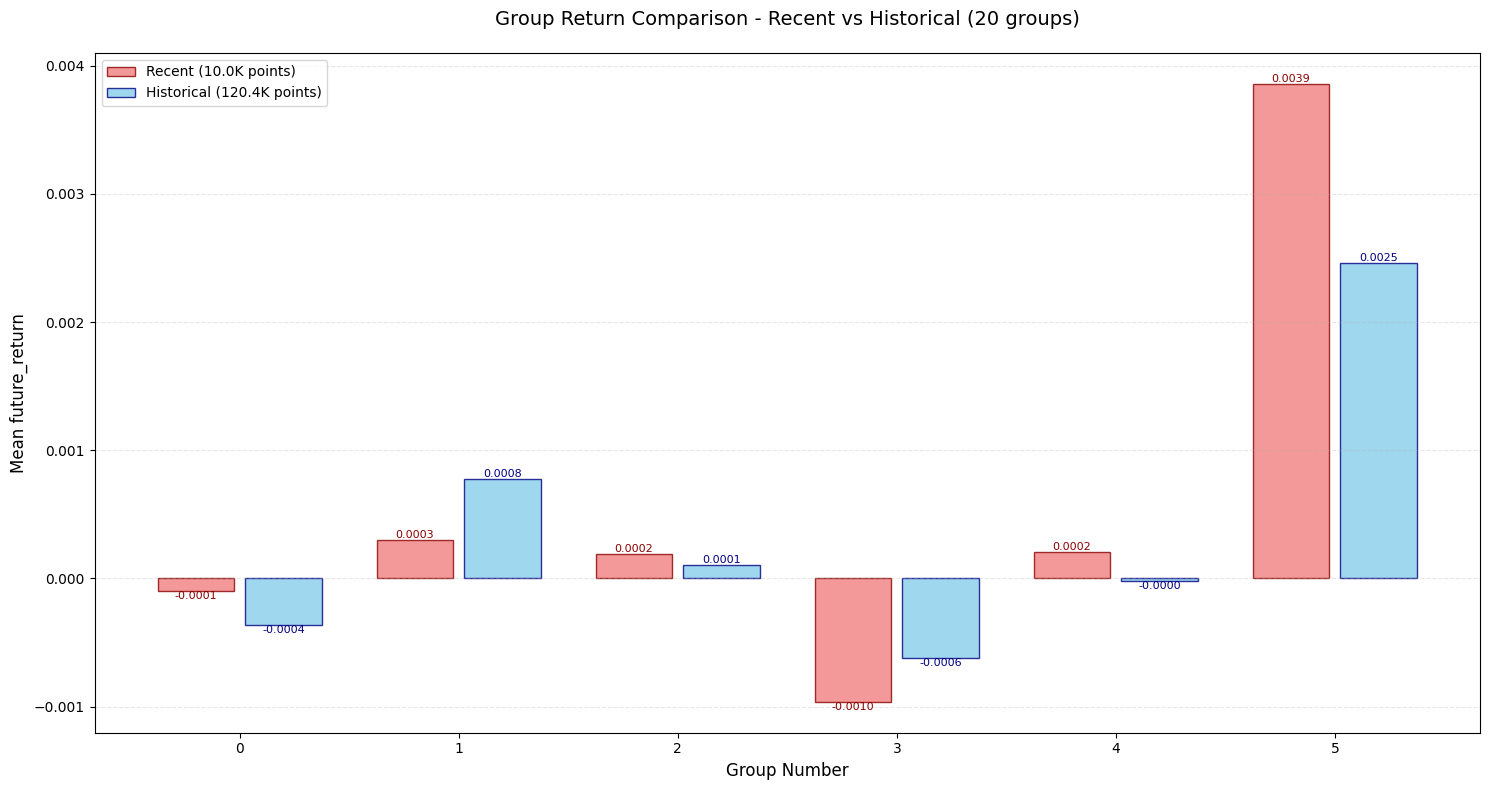

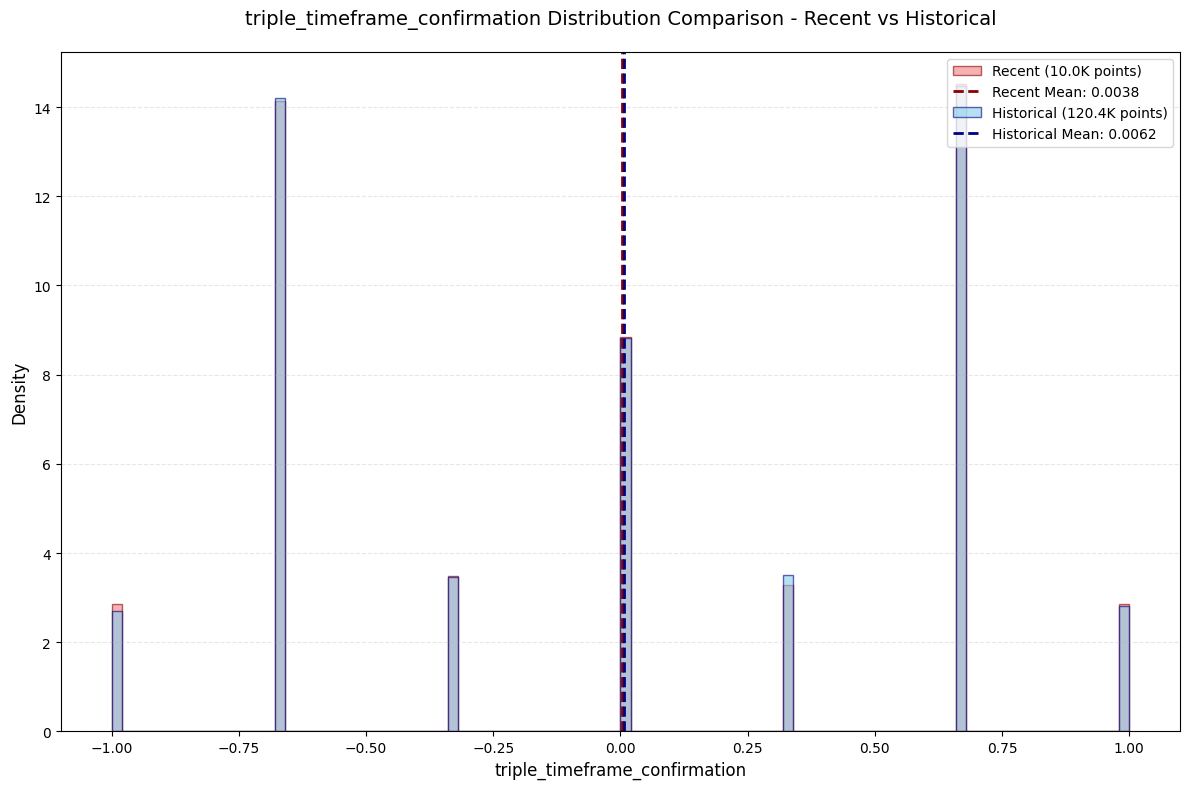

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=True)